In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import numpy as np
import pandas as pd
import librosa.display

def exclude(audio_file, labels_file):
    # Load audio file
    y, sr = librosa.load(audio_file)

    # Load labels file as pandas dataframe
    df = pd.read_csv(labels_file, delimiter='\t')

    # Convert start and end times to sample indices
    start_idx = librosa.time_to_samples(df['Begin Time (s)'], sr=sr)
    end_idx = librosa.time_to_samples(df['End Time (s)'], sr=sr)

    # Create a boolean mask for each frame
    frames = librosa.util.frame(y, frame_length=sr, hop_length=sr).T
    mask = np.ones(frames.shape[0], dtype=bool)

    # Loop over each interval and exclude corresponding frames
    for idx in range(len(start_idx)):
        start_frame = start_idx[idx] // sr
        end_frame = end_idx[idx] // sr
        mask[start_frame:end_frame+1] = False

    # Apply mask to frames
    frames_filtered = frames[mask]

    # Reshape filtered frames into audio signal
    y_filtered = frames_filtered.reshape(-1)
    return y_filtered, sr


def load_audio_file(file_path, preprocessing=True,output_path=None):
    # SPECTROGRAM CONSTANTS
    # Window size (n_fft) in seconds
    
#     WINDOW_SIZE_SEC = 0.15

    WINDOW_SIZE_SEC = 0.18568
    HOP_LEN_SEC = 0.032

    # Proportion of spectrogram that reflects the minimum area hand-annotation boxes will be allowed to have
    MIN_BOX_AREA = 0.0006
    
    if isinstance(file_path, str):
        audio, sr = librosa.load(file_path)
    else:
        audio = file_path
        sr = 22050

    n_fft = int(WINDOW_SIZE_SEC * sr)
#     print(n_fft)
    hop_length = int(HOP_LEN_SEC * sr)

    if preprocessing: 
        audio_stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        audio_mag = np.abs(audio_stft)**2
        
        # Define PCEN hyperparameters
        alpha = 0.98
        delta = 2.0
        r = 0.5
        eps = 1e-6

        pcen = librosa.pcen(audio_mag, sr=sr, hop_length=hop_length, gain=r, bias=delta, power=alpha, time_constant=0.4)

        # Add a new axis to the tensor
        pcen = np.expand_dims(pcen, axis=-1)
        
        # Output PCEN-transformed audio to WAV file
        if output_path is not None:
            audio_recov = librosa.istft(audio_stft * np.sqrt(np.squeeze(pcen)))
            sf.write(output_path, audio_recov, sr, 'PCM_24')
            print("done")
    
        return np.transpose(pcen, (1, 0, 2))
    return audio

def instantiate_dataset(location, preprocessing=True, batch_size=60, validation_split=0.1,running=False,labels=None):
    if labels is not None:
        audio, sr = exclude(location,labels)
    else:
        audio, sr = librosa.load(location)
    # Determine the number of one-second intervals in the audio file
    num_segments = len(audio) // sr
#     segments = librosa.util.frame(audio, frame_length=sr, hop_length=sr).T
    
    # Load each segment and preprocess it
#     data = np.array([load_audio_file(segment, preprocessing) for segment in segments])
    
    
    
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.io import wavfile
    audio=load_audio_file(audio,preprocessing)
    fig, ax = plt.subplots()
    audio=audio.squeeze(axis=2)
    print(audio.shape)
    img = librosa.display.specshow(librosa.amplitude_to_db(audio,
                                                           ref=np.max),
                                   y_axis='log', x_axis='time', ax=ax)
    
    ax.set_title('Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    plt.show()
    return audio, sr
    
    
    


In [2]:
import os
normal_path="avila_filtered.wav"
non_normal_path="../decimated-wavs/671658014.180928183606_processed.wav"
processedWav = [i for i in os.listdir() if i.endswith("_processed.wav")][0]
processedWav

'6805.230206163827_processed.wav'

(36500, 2048)


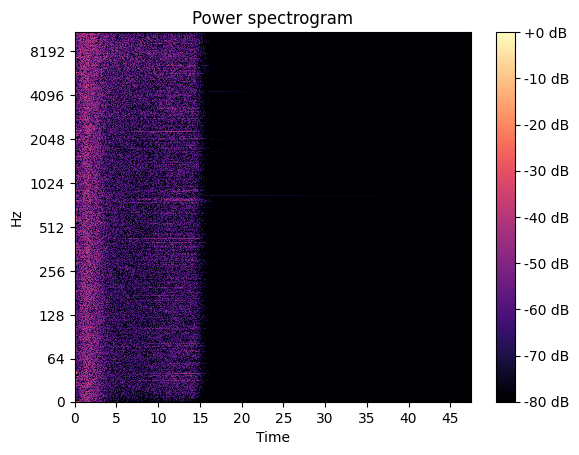

In [3]:
formatted = processedWav.replace("_processed.wav", "")
labels = f'{formatted}-SS.txt'
normal, sr = instantiate_dataset(normal_path,running=True,labels=labels)

In [4]:
non_normal, sr = instantiate_dataset(non_normal_path,running=True)

/var/folders/76/d_0wxmhs22vczt61znyh06840000gn/T/ipykernel_47781/3438814370.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(location)
/usr/local/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '../decimated-wavs/671658014.180928183606_processed.wav'

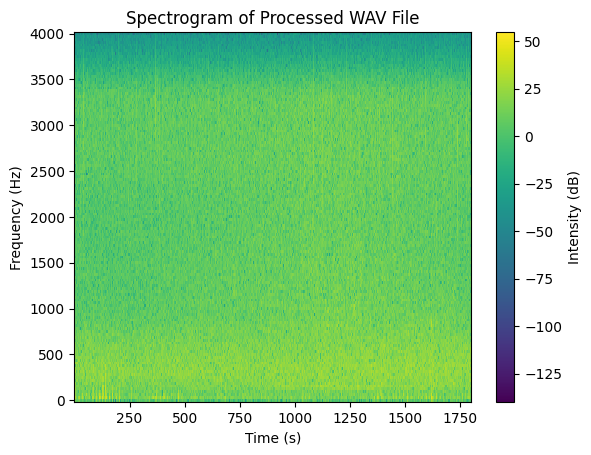

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram

# Load the processed WAV file
file_path = '/Users/sucheen/Documents/Cal Poly SLO/Academics/Year 4/Winter 2024/DATA 451-01/bioacoustics2/previous/6805.230201090825_processed.wav'
filePath = 'avila_filtered.wav'
sample_rate1, audio_data1 = wavfile.read(file_path)
sample_rate2, audio_data2 = wavfile.read(filePath)

# Create a spectrogram
frequencies1, times1, spectrogram1 = spectrogram(audio_data1, fs=sample_rate1)
frequencies2, times2, spectrogram2 = spectrogram(audio_data2, fs=sample_rate2)

# Plot the spectrogram
plt.pcolormesh(times1, frequencies1, 10 * np.log10(spectrogram1), shading='auto')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram of Processed WAV File')
plt.colorbar(label='Intensity (dB)')
plt.show()

In [ ]:
from scipy.signal import correlate2d

def measure_similarity(spectrogram1, spectrogram2):
    # Compute the 2-dimensional cross-correlation between the two spectrograms
    correlation = correlate2d(spectrogram1, spectrogram2)

    # The peak of the cross-correlation matrix can be considered as a measure of similarity
    similarity = correlation.max()

    return similarity

# Assuming `spectrogram1` and `spectrogram2` are your two spectrograms
similarity = measure_similarity(spectrogram1, spectrogram2)
print(f"The similarity between the two spectrograms is: {similarity}")